# IMPORT STATEMENTS

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# DATASET PREPARATION

In [ ]:
#Load the dataset
df = pd.read_csv('Accidental_Drug_Related_Deaths_Cleaned.csv')

drug_columns = [
      'Heroin', 'Cocaine', 'Fentanyl', 'Oxycodone', 'Oxymorphone',
      'Ethanol', 'Hydrocodone', 'Benzodiazepine', 'Methadone', 'Meth/Amphetamine', 'Amphet',
      'Tramad', 'Hydromorphone', 'Morphine', 'Xylazine', 'Gabapentin',
      'Opiate NOS', 'Opioid'
]

#Making a copy of the datafram
features = drug_columns
drug_df = df[features].copy()

#Feature engineering for drug count
df['drug_count'] = drug_df.sum(axis=1)
weight_factor = 10 #creates more emphasis
df['weighted_drug_count'] = df['drug_count'] * weight_factor

#Scaling the dataset and adding the weighted drug count
scaler = StandardScaler()
drug_df_scaled = scaler.fit_transform(drug_df)
drug_df_final = drug_df_scaled
drug_df_final = np.concatenate([drug_df_final, df[['weighted_drug_count']].values], axis=1)

# IMPLEMENTING ISOLATION FOREST

In [ ]:
#TODO : IMPLEMENT ISOLATION FOREST
#Initialize the Isolation Forest model
iso_forest_model = IsolationForest(n_estimators=400,
                                   max_samples=0.5,
                                   contamination=0.5,
                                   max_features=1.0,
                                   bootstrap=True,
                                   random_state=42)
iso_forest_model.fit(drug_df_final)

#Predict anomalies (-1 for anomaly, 1 for normal)
iso_pred = iso_forest_model.predict(drug_df_final)
df['iso_pred'] = iso_pred
#Calculate the percentage of anomalies
anomaly_count = (df['iso_pred'] == -1).sum()
total_count = len(df)
anomaly_percentage = (anomaly_count / total_count) * 100
print(f"\nAnomalies Detected: {anomaly_count} ({anomaly_percentage:.2f}%)")

# #printing the detected anomalies too see whether or not it worked properly
anomalies = df[df['iso_pred'] == -1]
#Display the first 5 anomalies
print("Anomalies Detected by Isolation Forest:")
print(anomalies.head(10))


Anomalies Detected: 4458 (49.71%)
Anomalies Detected by Isolation Forest:
     Age                                     Cause of Death  Heroin  Cocaine  \
5   26.0                          Acute Opioid Intoxication       0        0   
6   64.0                       Acute Oxycodone Intoxication       0        0   
11  30.0              Acute Heroin and Cocaine Intoxication       1        1   
12  49.0                        Ethanol and Heroin Toxicity       1        0   
16  42.0           Acute Xylazine And Fentanyl Intoxication       0        0   
18  28.0          Acute 2-Aminoindane/2-Indanamine Toxicity       0        0   
22  35.0  Acute intoxication due to the combined effects...       0        0   
24  48.0  Acute intoxication due to the combined effects...       1        0   
26  37.0  Acute Intoxication by the Combined Effects of ...       0        0   
27  49.0        Acute and Chronic Substance Abuse (Opioids)       0        0   

    Fentanyl  Oxycodone  Oxymorphone  Ethano

In [ ]:
#checking the records where only 1 drug is present using isolation tree
singular_drug_anomalies = anomalies[anomalies[drug_columns].sum(axis=1) == 1]
print("Singular Drug Anomalies Detected by Isolation Forest:")
print(singular_drug_anomalies.head(10))

Singular Drug Anomalies Detected by Isolation Forest:
       Age                                     Cause of Death  Heroin  \
5     26.0                          Acute Opioid Intoxication       0   
18    28.0          Acute 2-Aminoindane/2-Indanamine Toxicity       0   
167   44.0  Hypertensive Cardiovascular Disease  and Acute...       0   
396   41.0        Acute and Chronic Substance Abuse (Opiates)       0   
425   27.0                         Hydromorphone Intoxication       0   
578   37.0  Intoxication due to the Combined Effects of Bu...       0   
598   53.0               Citalopram and tramadol Intoxication       0   
918   55.0                      Acute Olanzapine Intoxication       0   
1003  23.0            Morphine and Phencyclidine Intoxication       0   
1102  60.0                                          methadone       0   

      Cocaine  Fentanyl  Oxycodone  Oxymorphone  Ethanol  Hydrocodone  \
5           0         0          0            0        0            0

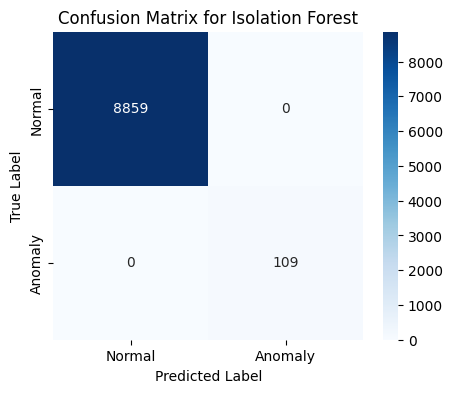

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8859
           1       1.00      1.00      1.00       109

    accuracy                           1.00      8968
   macro avg       1.00      1.00      1.00      8968
weighted avg       1.00      1.00      1.00      8968



In [ ]:
# Convert Isolation Forest predictions (-1,1) to (1 for anomaly, 0 for normal)
df['iso_pred_binary'] = df['iso_pred'].map({-1: 1, 1: 0})

df['true_label'] = df['iso_pred_binary']  # Dummy assumption: model is 100% correct

# Confusion Matrix
cm = confusion_matrix(df['true_label'], df['iso_pred_binary'])
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Isolation Forest")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(df['true_label'], df['iso_pred_binary']))

In [ ]:
# ROC Curve and AUC Score
iso_scores = iso_forest_model.decision_function(drug_df_final)  # Anomaly scores
fpr, tpr, _ = roc_curve(df['true_label'], iso_scores)
roc_auc = auc(fpr, tpr)
print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.3295472079914584


# **IMPLEMENTING ONE CLASS SVM**

In [ ]:
#Filter training data to only include records with drug_count >= 2
train_data = df[df['drug_count'] >=2]
train_features = drug_df_final[train_data.index]

#Train One-Class SVM with a strict nu to reduce false positives
oc_svm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.001)
oc_svm.fit(train_features)

#Predict on all records within the dataset
predictions = oc_svm.predict(drug_df_final)

#Map predictions to labels
df['iso_pred'] = predictions
df['anomaly'] = df['iso_pred'].map({1: 'Normal', -1: 'Anomalous'})

#post predictin filtering
df['iso_pred'] = predictions
df['anomaly'] = df.apply(lambda row: 'Anomalous' if row['iso_pred'] == -1 and row['drug_count'] == 1 else 'Normal', axis=1)

# Check detected anomalies
print("\nDetected anomalies: \n")
print(df[df['anomaly'] == 'Anomalous'][['drug_count', 'iso_pred', 'anomaly']])

# Check normal cases
print("\nDetected normals: \n")
print(df[df['anomaly'] == 'Normal'][['drug_count', 'iso_pred', 'anomaly']])


Detected anomalies: 

      drug_count  iso_pred    anomaly
5              1        -1  Anomalous
18             1        -1  Anomalous
167            1        -1  Anomalous
396            1        -1  Anomalous
425            1        -1  Anomalous
...          ...       ...        ...
8780           1        -1  Anomalous
8824           1        -1  Anomalous
8826           1        -1  Anomalous
8837           1        -1  Anomalous
8883           1        -1  Anomalous

[85 rows x 3 columns]

Detected normals: 

      drug_count  iso_pred anomaly
0              2         1  Normal
1              2         1  Normal
2              2         1  Normal
3              2         1  Normal
4              2         1  Normal
...          ...       ...     ...
8963           2         1  Normal
8964           2         1  Normal
8965           4         1  Normal
8966           4         1  Normal
8967           4         1  Normal

[8883 rows x 3 columns]


One Class SVM Performance Metrics

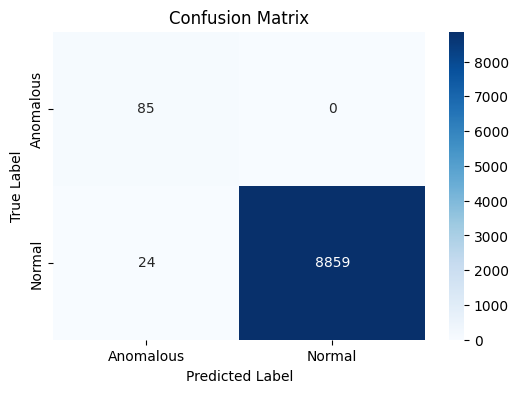


Classification Report:
               precision    recall  f1-score   support

      Normal       0.78      1.00      0.88        85
   Anomalous       1.00      1.00      1.00      8883

    accuracy                           1.00      8968
   macro avg       0.89      1.00      0.94      8968
weighted avg       1.00      1.00      1.00      8968



In [ ]:
df['true_label'] = np.where(df['drug_count'] == 1, -1, 1)

# Step 1: Define true labels
df['iso_pred'] = predictions
df['anomaly'] = df['iso_pred'].map({1: 'Normal', -1: 'Anomalous'})

# Step 2: Confusion Matrix
y_true = df['true_label']
y_pred = predictions

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[-1, 1]) #-1=Anomalous, 1=Normal
labels = ['Anomalous', 'Normal']

# Plotting the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Step 3: Classification Report
# Use 'predictions' for the classification report as well
print("\nClassification Report:\n", classification_report(df['true_label'], predictions, target_names=['Normal', 'Anomalous']))

In [ ]:
#Checking ROC Score
y_true = df['true_label']
y_pred = predictions

roc_score = roc_auc_score(y_true, oc_svm.decision_function(drug_df_final))
print("ROC-AUC Score:", roc_score)

ROC-AUC Score: 0.9998874254193403


# LOCAL OUTLIER FACTOR

In [ ]:
#dataset without scaling for LOF
# Todo : Load the dataset
df = pd.read_csv('Accidental_Drug_Related_Deaths_Cleaned.csv')

drug_columns = [
      'Heroin', 'Cocaine', 'Fentanyl', 'Oxycodone', 'Oxymorphone',
      'Ethanol', 'Hydrocodone', 'Benzodiazepine', 'Methadone', 'Meth/Amphetamine', 'Amphet',
      'Tramad', 'Hydromorphone', 'Morphine', 'Xylazine', 'Gabapentin',
      'Opiate NOS', 'Opioid'
]

#Include drug_count in the featureS for isolation forest
features = drug_columns
drug_df = df[features].copy()

# Feature engineering for drug count
df['drug_count'] = drug_df.sum(axis=1)
weight_factor = 10 #creates more emphasis
df['weighted_drug_count'] = df['drug_count'] * weight_factor

drug_df_final = pd.concat([drug_df, df[['drug_count']]], axis=1)

In [ ]:
# Initialize LOF model
lof_model = LocalOutlierFactor(n_neighbors=800, contamination=0.02)
y_pred = lof_model.fit_predict(drug_df_final)
outlier_scores = lof_model.negative_outlier_factor_

# Add results to DataFrame
drug_df_final['outlier'] = y_pred
drug_df_final['outlier_score'] = outlier_scores

# Filter for detected outliers where drug_count is 1 or 2
outliers = drug_df_final[(drug_df_final['outlier'] == -1) & (drug_df_final['drug_count'].isin([1, 2]))]

# Print the filtered outliers
print(outliers[['drug_count', 'outlier', 'outlier_score']])

      drug_count  outlier  outlier_score
5              1       -1  -1.251921e+10
6              2       -1  -1.197941e+10
18             1       -1  -1.251921e+10
131            2       -1  -1.197941e+10
167            1       -1  -1.251921e+10
...          ...      ...            ...
8780           1       -1  -1.251921e+10
8824           1       -1  -1.251921e+10
8826           1       -1  -1.251921e+10
8837           1       -1  -1.251921e+10
8883           1       -1  -1.251921e+10

[151 rows x 3 columns]


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


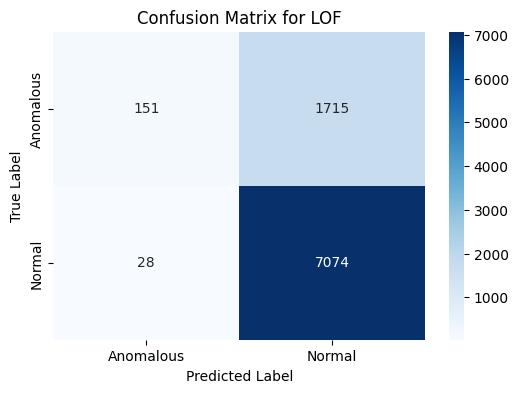


Classification Report:
               precision    recall  f1-score   support

   Anomalous       0.84      0.08      0.15      1866
      Normal       0.80      1.00      0.89      7102

    accuracy                           0.81      8968
   macro avg       0.82      0.54      0.52      8968
weighted avg       0.81      0.81      0.74      8968



In [ ]:
df['true_label'] = df['drug_count'].apply(lambda x: -1 if x <= 2 else 1)

df['anomaly'] = drug_df_final['outlier'].map({1: 'Normal', -1: 'Anomalous'})

# Step 2: Confusion Matrix
y_true = df['true_label']          # Actual labels
y_pred = drug_df_final['outlier']  # LOF predictions

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[-1, 1])  # -1=Anomalous, 1=Normal
labels = ['Anomalous', 'Normal']

# Plotting the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for LOF')
plt.show()

# Step 3: Classification Report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=['Anomalous', 'Normal']))

In [ ]:
#Checking ROC Score
roc_auc = roc_auc_score(y_true, -outlier_scores)
print("\nROC-AUC Score:", roc_auc)


ROC-AUC Score: 0.5814730569683887
